# About This Notebook

This notebook is designed to facilitate the use of pychip locally without using the App. 
<br>
After setting up your kernel and importing required packages this notebook will guide you through the following steps:
1. Designate filepaths and names for your inputs and outputs
1. Indicate how many rows/columns the image should be splintered into
1. Initialize the classifier and create chips
1. Design your support set
1. Run the few shot classifier
1. Interpret results

## Optional: Set up virtual environment



### Here are steps to ensure that your virtual environment is set up as a kernel for running this notebook:
1. Install and activate conda
2. Run the following commands to create and activate an environment: 
    - conda create -n myenv
    - conda activate myenv
4. Navigate to the same folder with the requirements.txt file and run the following commands to set up the environment: 
    - conda install pip
    - pip3 install -r requirements.txt
5. Run the following commands to set up a kernel that can be used in jupyter notebook:
    - pip install --user ipykernel
    - python -m ipykernel install --user --name=myenv
6. Now you should see 'myenv' as an option in the dropdown list of available Kernels when jupyter notebook is running

## Import Required Packages

Note: This is designed to be run from within the few-shot-electron-microscopy directory. If your jupyter notebook is running from elsewhere, you may need to adjust some of these import statements.

In [4]:
pip install -r requirements.txt 

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.3.4-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)
  Using cached opencv_python-4.2.0.34-cp38-cp38-manylinux1_x86_64.whl (28.2 MB)
  Using cached shap-0.41.0-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (575 kB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached jsonschema-3.0.2-py2.py3-none-any.whl (54 kB)
Processing /qfs/people/belo700/.cache/pip/wheels/11/f0/b0/a8f9944f274bbc0f0159f2268f43dadcfa1cfe50a9007d8e1f/librosa-0.7.2-py3-none-any.whl
Processing /qfs/people/belo700/.cache/pip/wheels/25/4e/74/1b098f6faf8ef2aac0f1e92144fac48ae50f647faeeff566dd/numba-0.45.0-cp38-cp38-linux_x86_64.whl
  Using cached tensorflow-2.3.0-cp38-cp38-manylinux2010_x86_64.whl (320.5 MB)
  Using cached Keras-2.3.0-py2.py3-none-any.whl (377 kB)
  Using cached Pillow-8.0.1-cp38-cp38-manylinux1_x86_64.whl (2.2 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Usi

  Using cached google_auth-2.17.3-py2.py3-none-any.whl (178 kB)
  Using cached Markdown-3.4.3-py3-none-any.whl (93 kB)
  Using cached Werkzeug-2.3.3-py3-none-any.whl (242 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached cachetools-5.3.0-py3-none-any.whl (9.3 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Using cached pyasn1-0.5.0-py2.py3-none-any.whl (83 kB)
ERROR: pychip 0.0.5 has requirement numpy==1.19.4, but you'll have numpy 1.23.5 which is incompatible.
ERROR: pychip 0.0.5 has requirement opencv-python==4.5.1.48, but you'll have opencv-python 4.2.0.34 which is incompatible.
ERROR: pychip 0.0.5 has requirement pandas==1.2.0, but you'll have pandas 2.0.1 which is incompatible.
ERROR: pychip 0.0.5 has requirement torch==1.7.1, but you'll have torch 1.10.1 which is incompatible.
ERROR: pychip 0.0.5 has requirement torch

In [1]:
import pandas as pd
import numpy as np
import os
import Helper
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from accuracy_winnow.get_accuracy import get_acc, get_best_model, get_feat, get_val, sort_feat, get_scalar, create_heatmap, MyEnsemble, get_test_data, format_output, MyEnsemble2, get_conf_mat
from few_shot.resnet import resnet18, resnet34, resnet50, resnet101, resnet152
import torchvision.models as models
from few_shot.protonet import PrototypicalNet
import glob
import shutil
from few_shot.pychip_classifier import PychipClassifier
from IPython.display import Image, display, Markdown
%matplotlib inline

Using TensorFlow backend.


In [2]:
f = open("data/LiAl/backup/LiAl_truth_df_updated.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
text = ""
t_arr = []
for i in data[1:]:
    if len(i)>1:
        tt = i.replace("\"", "")
        temp_arr = tt.split(",")
        XY_arr = temp_arr[0].split("Y")
        XY_arr[0] = XY_arr[0].replace("X", "")
        XY = "R"+XY_arr[1]+"C"+XY_arr[0]
        tt = XY+","+temp_arr[1]
        #tt = tt.replace("X", "R")
        t_arr.append(tt+"\n")
t_arr = sorted(t_arr)
text = data[0].replace("\"", "") + "\n"
for i in t_arr: #[:-1]:
    text += i
f = open("data/LiAl/LiAl_truth_df.csv", "w")
f.write(text)
f.close()

## Step 1: Designate filepaths and names for inputs and outputs

you may use exact or relative locations for these paths

In [3]:
# data_path is the base directory you will be working out of:
#data_path = "./data/particles_on_carbon_mesh"
#data_path = "./data/STO_GE_2"
#data_path = "./data/BiTE_1"
#data_path = "./data/BiTE_2"
data_path = "./data/LiAl"

# img_name is the filename of the image you want to analyze (within the data_path folder)
#img_name = "montage05_03_2022 14_27_35.265_cropped.bmp"
#img_name = "STO_GE_2.jpg"
#img_name = "BiTE_1.jpg"
#img_name = "BiTE_2.jpg"
img_name = "LiAl.png"

# results_path is the folder your results will save to
results_path = "./testing"

# chips_path is the folder your chips will save to (if you choose to save them)
chips_path = "./testing/chips"

## Step 2: Indicate how many rows/columns the image should be splintered into

You will be able to preview the size of chip created, and re run this section as many times as you'd like before creating the actual chips

In [4]:
# n_columns is the number of columns your image will be chipped in to
n_columns = 128 #50 #64 #50 #128 #50 #64
n_rows = 96 #50 #48 #50 #96 #50 #48


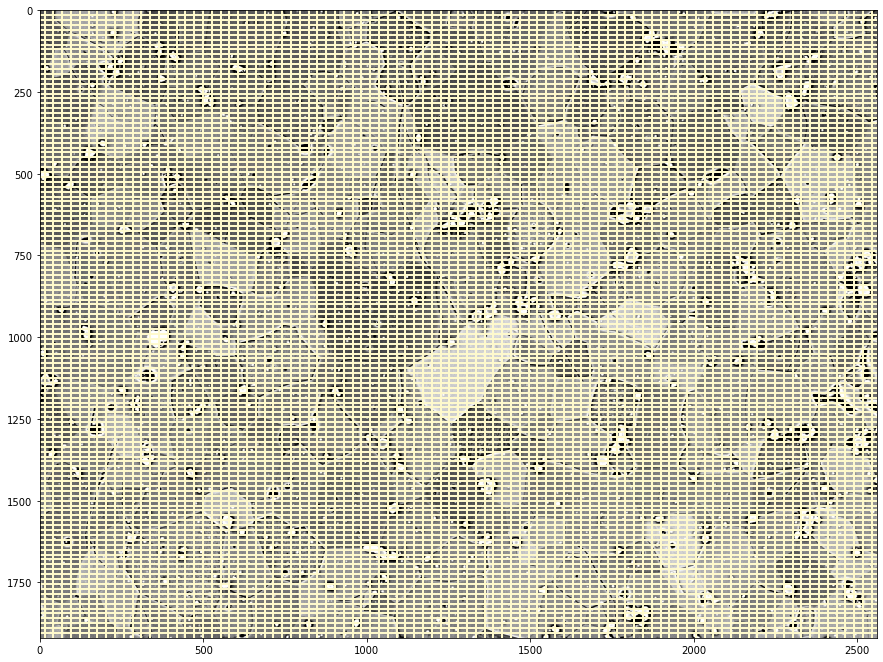

In [5]:
# Preview the chip size 
# Assumes image is square. If not, there may be distortions in this preview that will not appear in the final chipped image
img_path = os.path.join(data_path, img_name)

img = mpimg.imread(img_path)
width = img.shape[0]
chipsize = width/n_columns
height = img.shape[1]
chipheight = height/n_rows
x_grid_lst = np.linspace(chipsize, width-chipsize, n_columns-1)
y_grid_lst = np.linspace(chipsize, height-chipsize, n_rows-1)

plt.figure(figsize=(15, 15))
imgplot = plt.imshow(img)
for x_loc in x_grid_lst:
    for y_loc in y_grid_lst:
        plt.axhline(y=x_loc, c='lemonchiffon')
        plt.axvline(x=y_loc, c='lemonchiffon')

## Step 3: Initialize the classifier and create chips

This classifier gives you the option of saving a copy of the preprocessed image and/or the chips. If you'd rather not save things, don't pass in the savepath parameter. If you do want to save things, you'll need to provide the savepath as well as either a name or a file type (for preprocess or chips, respectively). An example of each scenario can be found here:

To save the preprocessed image:

```classifier.preprocess("CLAHE", savepath=results_path, img_name="preprocessed.jpg", clipLimit=2.0)```

To NOT save the preprocessed image:

```classifier.preprocess("CLAHE", clipLimit=2.0)```

To save the chips:

```classifier.chips_genesis(n_columns, savepath=chips_path, imgs_ext=".jpg")```

To NOT save the chips:

```classifier.chips_genesis(n_columns)```

In [6]:
classifier = PychipClassifier(data_path, img_name)
classifier.preprocess("CLAHE", clipLimit=2.0)
classifier.chips_genesis(n_rows, n_columns) #, savepath=chips_path, imgs_ext=".jpg")

tileGridSize not provided for CLAHE preprocess - using default value: (8,8)
(1920, 2560, 3)


## Step 4: Define your support set

You have two options for defining a support set:
- A filepath
- A dictionary

If you already have chips saved on your computer that you want to use as support sets, follow the instructions in the [Support set from filepath](#filepath) section

Otherwise, follow the instructions in the [creating a support set dictionary](#dictionary) section.


<a id="filepath"></a>
### Support set from filepath

Your file structure should look like this:
```
supports
└───set_1_label
│   │   R23C0.jpg
│   │   R21C21.jpg
│   │   R32C17.jpg
└───set_2_label
│   │   ...
└───set_3_label
│   │   ...
```

In [7]:
# update this if necessary
support_folder = "./support"

#classifier.support_genesis(support_path=support_path)

<a id="dictionary"></a>
### Creating a support set dictionary


Chip names have the format R#C# (row# column#)
<br>
for an image with 10 rows and 10 columns:
   - the top left chip is R0C0
   - the top right chip is R0C9
   - the bottom left chip is R9C0
   - the bottom right chip is R9C9
   
<br>

Run the next cell for a reference map of available chips in your image, then adjust the following ```support_dict``` as necessary. You will need one key for each support set. Each key maps to a list of representative chips using the above naming convention. The lists of chips can be any length (between 1-9 chips each is recommended)

In [ ]:
fig, axs = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(20, 20))

for row in range(n_rows):
    for column in range(n_columns):
        chip_name = f"R{row}C{column}"
        chip = classifier.chips[chip_name]
        axs[row, column].imshow(chip)
        #axs[row, column].axis('off')
        axs[row, column].set_yticklabels([])
        axs[row, column].set_yticks([])
        axs[row, column].set_xticklabels([])
        axs[row, column].set_xticks([])
        
        if row == 0:
            axs[row, column].set_title(f"C{column}")
        if column == 0:
            axs[row, column].set_ylabel(f"R{row}")
            
plt.savefig("chips.png")        
plt.show()

In [8]:
support_dict = {'particle': ['R29C0', 'R21C21', 'R32C17'],
                'set_2_label': ['R20C7', 'R15C10', 'R10C20'],
                'set_3_label': ['R0C12', 'R1C9', 'R2C3']}

While you're at it, udpate the set labels in the dictionary of colors below if necessary. You can also adjust their associated colors (which will appear in the resulting segmented image)

In [9]:
color_dict = {'particle': (255, 0, 0),
              'set_2_label': (0, 255, 0),
              'set_3_label': (0, 0, 255),
              'no_label': (255, 255, 255)}

To confirm that your support sets look correct, run the following:

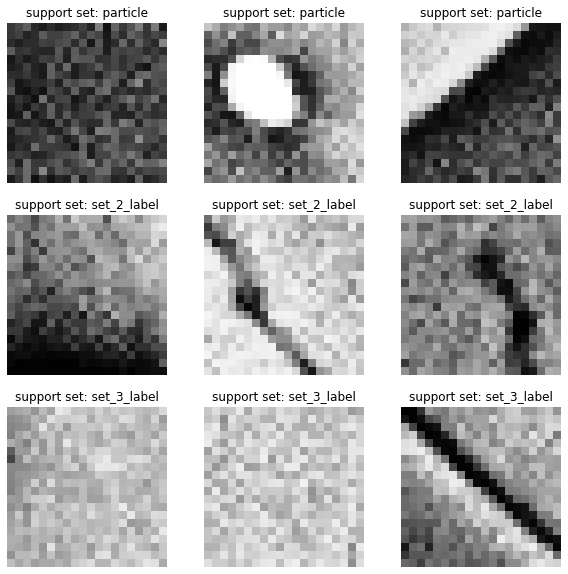

In [10]:
rows = len(support_dict.keys())
columns = max([len(support_dict[x]) for x in list(support_dict.keys())])

fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 10))

for row, sup_set in enumerate(support_dict.keys()):
    for col, chip_name in enumerate(support_dict[sup_set]):
        chip = classifier.chips[chip_name]
        axs[row, col].imshow(chip)
        axs[row, col].axis('off')
        axs[row, col].set_title(f"support set: {sup_set}")
plt.show()

Once your support set is satisfactory, run the following to pass it to the classifier:

In [11]:
from PIL import Image
#from sklearn.neighbors import NearestNeighbors
import math
pil_image = Image.open(img_path) #'images/montage05_03_2022.bmp')
img_og = np.asarray(pil_image)
img = np.asarray(pil_image)
img_og = img_og[:,:,0]
img_og = img_og.reshape((img_og.shape[0], img_og.shape[1]))
#img_og = img_og[::2]
print(img_og.shape)
x = np.unique(img_og)
group = 3
ind = round((len(x)/group))
dd = {}
for i in range(group):
    dd[i] = x[i*ind:(i+1)*ind]

(1920, 2560)


In [12]:
#Getting the chips of the images
num_cols = 128 #64 #128 #64 #50 
num_rows = 96 #48 #96 #48 #50 
img_shape = img_og.shape
height = img_shape[0]
width = img_shape[1]
chip_size = round(math.floor(width / num_cols)) #/math.floor(height / num_rows))
print(chip_size)
print(width)
num_chips_x = math.floor(width / chip_size) #num_cols  # math.floor(width / chip_size)
num_chips_y = math.floor(height / chip_size) # num_rows #math.floor(self.height / self.chip_size)
pixels_ignored_in_x = width % chip_size
pixels_ignored_in_y = height % math.floor(height / num_rows) #self.chip_size
x_coords = list(range(0, width, chip_size))
y_coords = list(range(0, height, math.floor(height / num_rows))) #self.chip_size))
grid_points = []

# Filling the grid_points. This is used when creating the chips.
for col_idx, x_coord in enumerate(range(0, width - pixels_ignored_in_x, chip_size)):
    for row_idx, y_coord in enumerate(range(0, height - pixels_ignored_in_y, chip_size)):
        grid_points.append((x_coord, y_coord, row_idx, col_idx))

# Cropping the image of desired.
# this may only work if grey
img = img[0:height - pixels_ignored_in_y, 0:width - pixels_ignored_in_x]

chips = {}

# Creating the chips
# self.grid_points.append((x_coord, y_coord, row_idx, col_idx))
for x, y, R_idx, C_idx in grid_points:
    name = f"R{R_idx}C{C_idx}"  # Naming convention for the chips
    chips[name] = img[y:y + chip_size, x:x + chip_size]

20
2560


In [13]:
#feat = get_feat("/people/belo700/CHESS/pychip-classifier/data/STO_GE_2/STO_GE_2_truth_df.csv")
#val = get_val("/people/belo700/CHESS/pychip-classifier/data/STO_GE_2/STO_GE_2_truth_df.csv")
#feat = get_feat("data/BiTE_1/BiTE_1_truth_df.csv")
#val = get_val("data/BiTE_1/BiTE_1_truth_df.csv")
#feat = get_feat("data/BiTE_2/BiTE_2_truth_df.csv")
#val = get_val("data/BiTE_2/BiTE_2_truth_df.csv")
feat = get_feat("data/LiAl/LiAl_truth_df.csv")
val = get_val("data/LiAl/LiAl_truth_df.csv")
t = {}
#dd = {"precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label"}
for i in range(len(feat)):
    #if feat[i] in dd.keys():
    t[feat[i]] = val[i]
print(sorted(list(chips.keys())))  
tt = {}
for i in t.keys():
    if t[i] not in tt.keys():
        tt[t[i]] = []
    tt[t[i]].append(chips[i])

[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
['R0C0', 'R0C1', 'R0C10', 'R0C100', 'R0C101', 'R0C102', 'R0C103', 'R0C104', 'R0C105', 'R0C106', 'R0C107', 'R0C108', 'R0C109', 'R0C11', 'R0C110', 'R0C111', 'R0C112', 'R0C113', 'R0C114', 'R0C115', 'R0C116', 'R0C117', 'R0C118', 'R0C119', 'R0C12', 'R0C120', 'R0C121', 'R0C122', 'R0C123', 'R0C124', 'R0C125', 'R0C126', 'R0C127', 'R0C13', 'R0C14', 'R0C15', 'R0C16', 'R0C17', 'R0C18', 'R0C19', 'R0C2', 'R0C20', 'R0C21', 'R0C22', 'R0C23', 'R0C24', 'R0C25', 'R0C26', 'R0C27', 'R0C28', 'R0C29', 'R0C3', 'R0C30', 'R0C31', 'R0C32', 'R0C33', 'R0C34', 'R0C35', 'R0C36', 'R0C37', 'R0C38', 'R0C39', 'R0C4', 'R0C40', 'R0C41', 'R0C42', 'R0C43', 'R0C44', 'R0C45', 'R0C46', 'R0C47', 'R0C48', 'R0C49', 'R0C5', 'R0C50', 'R0C51', 'R0C52'

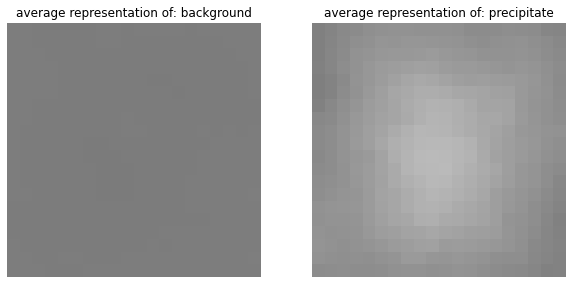

In [14]:
average_chips = {}
for i in tt.keys():
    t = np.array(tt[i])
    x1 = np.mean(t, axis=0)
    x = []
    for j in range(len(x1)):
        temp = []
        for d in range(len(x1[j])):
            temp1 = []
            for e in range(len(x1[j,d])):
                temp1.append(int(round((x1[j,d,e]))))
            temp.append(temp1)
        x.append(temp)
    average_chips[i] = np.array(x)


rows = 1
columns = len(average_chips.keys()) #max([len(average_chips[x]) for x in list(average_chips.keys())])

fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 10))

for row, sup_set in enumerate(average_chips.keys()):
    chip = average_chips[sup_set]
    axs[row].imshow(chip)
    axs[row].axis('off')
    axs[row].set_title(f"average representation of: {sup_set}")
plt.show()

In [15]:
classifier.support_genesis(support_dict=support_dict)

## Step 5: Run the few shot classifier

The preferred encoder is shufflenet (for speed and accuracy), but there are other options:
- resnet18
- resnet34
- resnet50
- resnet101
- resnet152
- torch101 (this is torch's resnet101)

In [34]:
import torch
import os
import math
from PIL import Image
from torch.nn import Softmax
import torch.optim as optim
import cv2
import torchvision.transforms as transforms

def cv2_to_PIL(cv2_img):
    PIL_img = transforms.ToTensor()(Image.fromarray(255 * cv2_img.astype(np.uint8)))
    return PIL_img

count = 0
n_columns = 128 #64 #128 #50 #64 #50 #128 
n_rows = 96 #48 #96 #50 #48 #50 #96 
sive = 2048

#feat = get_feat("data/STO_GE_2/STO_GE_2_truth_df.csv")
#val = get_val("data/STO_GE_2/STO_GE_2_truth_df.csv")

#feat = get_feat("data/BiTE_1/BiTE_1_truth_df.csv")
#val = get_val("data/BiTE_1/BiTE_1_truth_df.csv")

#feat = get_feat("data/BiTE_2/BiTE_2_truth_df.csv")
#val = get_val("data/BiTE_2/BiTE_2_truth_df.csv")

feat = get_feat("data/LiAl/LiAl_truth_df.csv")
val = get_val("data/LiAl/LiAl_truth_df.csv")

#dd = {"STO": "particle", "PtC": "set_3_label", "GE": "set_2_label"}
#dd = {"grain": "particle" , "void": "set_2_label"}
#dd = {"background": "particle", "precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label", "voidimpurity": "set_5_label", "precipitateimpurity": "set_6_label", "voidprecipitate": "set_7_label", "voidprecipitateimpurity": "set_8_label"}
dd = {"background": "particle", "precipitate": "set_3_label"} #, "NA":"ignore"}

new_feat = []
new_val = []
for x in range(len(feat)):
    new_feat.append(feat[x])
    if val[x] in dd.keys():
        new_val.append(val[x])
    #else:
    #    new_val.append("NA")
feat = new_feat
val = new_val
l = {}
for x in range(len(val)):
    if feat[x] not in l.keys(): #and feat[x] in dd.keys():
        l[feat[x]] = [dd[val[x]]]
    else:
        l[feat[x]].append(dd[val[x]])

ss = {}
for x in range(len(val)):
    if dd[val[x]] not in ss.keys():
        ss[dd[val[x]]] = [feat[x]]
    else:
        ss[dd[val[x]]].append(feat[x])

path_to_img = os.path.join(data_path, img_name)
pil_image = Image.open(path_to_img)

img_og = np.asarray(pil_image)
# the torch models we use require the input to have 3 channels. if there is only 1, we make more:
if len(img_og.shape) == 2:
    for_torch = np.zeros((img_og.shape[0], img_og.shape[1], 3))
    for_torch[:, :, 0] = img_og  # same value in each channel
    for_torch[:, :, 1] = img_og
    for_torch[:, :, 2] = img_og
    img = for_torch
else:
    img = np.asarray(pil_image)
    
clip_limit = 1.0
tile_grid_size = (8, 8)
clahe = cv2.createCLAHE(clip_limit, tile_grid_size)
if not isinstance(img.flat[0], np.uint8):
    print('cv2 requires different datatype, converting to uint8')
    img = img.astype(np.uint8)
    
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hsv_planes = cv2.split(hsv_img)
hsv_planes[2] = clahe.apply(hsv_planes[2])
hsv = cv2.merge(hsv_planes)
img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

img_shape = img_og.shape
height = img_shape[0]
width = img_shape[1]
chip_size = math.floor(width / n_columns)
num_chips_x = math.floor(width / chip_size) #n_columns  # math.floor(width / chip_size)
num_chips_y = math.floor(height / chip_size) #n_rows #math.floor(self.height / self.chip_size)
pixels_ignored_in_x = width % chip_size
pixels_ignored_in_y = height % math.floor(height / n_rows) #self.chip_size
x_coords = list(range(0, width, chip_size))
y_coords = list(range(0, height, math.floor(height / n_rows))) #self.chip_size))
grid_points = []

# Filling the grid_points. This is used when creating the chips.
for col_idx, x_coord in enumerate(range(0, width - pixels_ignored_in_x, chip_size)):
    for row_idx, y_coord in enumerate(range(0, height - pixels_ignored_in_y, chip_size)):
        grid_points.append((x_coord, y_coord, row_idx, col_idx))

# this may only work if grey
img = img[0:height - pixels_ignored_in_y, 0:width - pixels_ignored_in_x]

chips = {}
# Creating the chips
# self.grid_points.append((x_coord, y_coord, row_idx, col_idx))
for x, y, R_idx, C_idx in grid_points:
    name = f"R{R_idx}C{C_idx}"  # Naming convention for the chips
    chips[name] = img[y:y + chip_size, x:x + chip_size]

#print(chips)

# Creating the query_set (the chips to be classified)
img_chips = []
for chip_name in chips:
    # print('chips genesis, before cv2_to tensor, size:', self.chips[chip_name].shape)
    image = cv2_to_PIL(chips[chip_name])
    # print('chips genesis, after cv2_to tensor, size:', image.size())
    if chip_name in l.keys():
        img_chips.append([image, l[chip_name][0], chip_name])

corr = {}
eucl_dist = {}
img_chips2 = img_chips[::50]
#comp_area = 100
keys = []
for i in range(len(img_chips2)):
    ii1 = img_chips2[i][0].mean(0).detach().numpy()
    ii = ii1.reshape((ii1.shape[0]*ii1.shape[1],))
    name = img_chips2[i][2]
    keys.append(name)
    corr[name] = []
    eucl_dist[name] = []
    for j in range(len(img_chips2)):
        #if img_chips[j][1] in img_chips[i][1]:
        ii3 = img_chips2[j][0].mean(0).detach().numpy()
        ii2 = ii3.reshape((ii3.shape[0]*ii3.shape[1],))
        corr[name].append(np.corrcoef(ii,ii2)[0,1])
        eucl_dist[name].append(np.linalg.norm(ii-ii2))#-torch.cdist(img_chips[i][0], img_chips[j][0]))
print(eucl_dist)
#model = models.efficientnet_b0(pretrained=True)


[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
{'R0C0': [0.0, 2.4013996, 2.3178992, 2.6664503, 8.591824, 3.3968573, 2.0530598, 2.2029374, 2.1202815, 4.718576, 3.1669574, 10.602173, 2.07798, 2.9553254, 4.435856, 4.756181, 6.332368, 9.329484, 5.0467315, 7.9193683, 3.4426837, 6.775371, 3.989685, 5.5035257, 3.5851462, 8.620111, 4.00669, 2.2544756, 8.615836, 2.1402137, 7.1098094, 8.125675, 5.9448333, 4.044387, 9.0178795, 4.207547, 4.9992495, 8.369164, 3.252042, 3.31521, 5.3556037, 3.8797238, 4.0964704, 3.3781166, 7.4736986, 5.010823, 7.6971526, 9.539976, 3.726617, 8.41192, 2.7562153, 3.6681657, 3.809634, 2.4822445, 2.4797618, 2.3898122, 3.8331583, 5.6500974, 3.7909439, 4.1821723, 4.3707232, 5.516479, 2.2555497, 7.897313, 4.3599944, 7.036843, 5.749042, 4.99

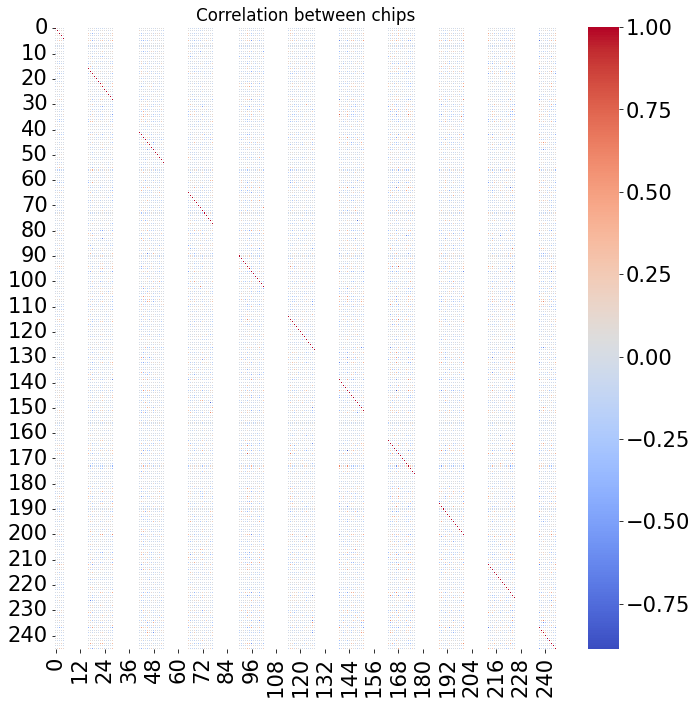

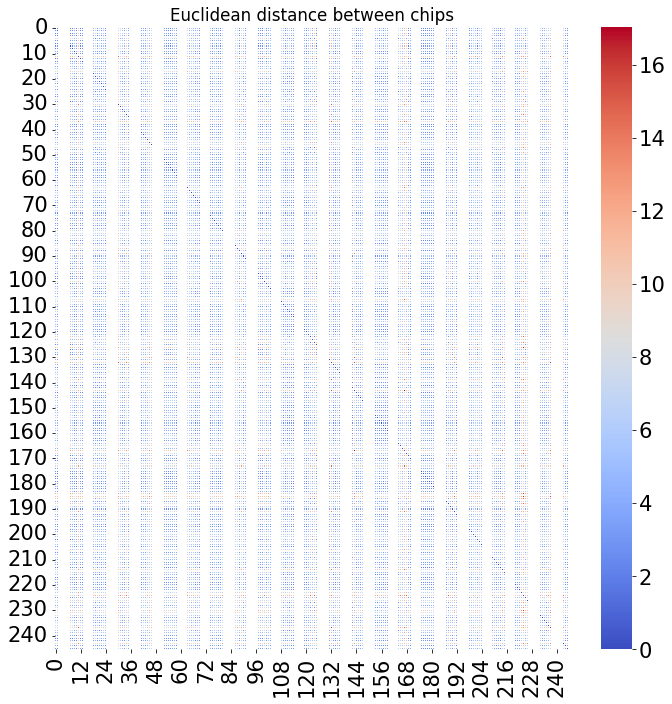

In [35]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

t = []
dist = []
for i in keys:
    t.append(corr[i])
    dist.append(eucl_dist[i])
t = np.array(t)
dist = np.array(dist)


plt.figure(figsize=(10, 10))
ax = sns.heatmap( t , linewidth = 0.5 , cmap = 'coolwarm' )
plt.title( "Correlation between chips" )
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
ax = sns.heatmap( dist , linewidth = 0.5 , cmap = 'coolwarm' )
plt.title( "Euclidean distance between chips" )
plt.tight_layout()
plt.show()

In [36]:
from scipy.spatial import distance
#corr = {}
eucl_dist = {}
#comp_area = 100
keys = []
#img_chips = img_chips[::10] #4]
for i in range(0,len(img_chips),4):
    ii = img_chips[i][0].mean(0).detach().numpy()
    #ii = ii1.reshape((ii1.shape[0]*ii1.shape[1],1))
    name = img_chips[i][2]
    keys.append(name)
    #corr[name] = []
    eucl_dist[name] = []
    for j in range(0,len(img_chips),4):
        if img_chips[j][1] in img_chips[i][1]:
            ii2 = img_chips[j][0].mean(0).detach().numpy()
            #ii2 = ii3.reshape((ii3.shape[0]*ii3.shape[1],1))
            #corr[name].append(np.corrcoef(ii,ii2)[0,1])
            eucl_dist[name].append(-distance.cdist(ii, ii2, 'euclidean')) #np.linalg.norm(ii-ii2))

In [37]:
reward = eucl_dist #{}
#for i in eucl_dist.keys():
#    temp = eucl_dist[i]
#    #print(t)
#    #t = []
#    #for j in temp:
#    #    tt = sum(j)/len(j)
#    #    t.append(sum(tt)/len(tt))
#    #max_val = max(t)
#    #max_corr = max(cc)
#    #tt = []
#    #for j in range(len(t)):
#    #    tt.append(-(t[j]/max_val))#(1/(1 + np.exp(-cc[j])))-(t[j]/max_val)) #-(1/(1 + np.exp(-t[j]))))
#    reward[i] = temp
#print(reward)

In [38]:
rew = []
for i in keys:
    rew.append(reward[i])
rew = np.array(rew)
high_rew = {}
for i in range(len(rew)):
    high_rew[keys[i]] = []
    for j in range(len(rew[i])):
        #if rew[i][j] < 0.25 or rew[i][j] == max(rew[i]):
        #    rew[i][j] = 0
        #else:
        high_rew[keys[i]].append(keys[j])
num_rel = {}
for i in keys:
    if len(high_rew[i]) not in num_rel:
        num_rel[len(high_rew[i])] = []
    num_rel[len(high_rew[i])].append(i)
sorted_keys = sorted(list(num_rel.keys()))
sorted_keys = sorted_keys[::-1]

#feat = get_feat("data/STO_GE_2/STO_GE_2_truth_df.csv")
#val = get_val("data/STO_GE_2/STO_GE_2_truth_df.csv")

#feat = get_feat("data/BiTE_1/BiTE_1_truth_df.csv")
#val = get_val("data/BiTE_1/BiTE_1_truth_df.csv")

#feat = get_feat("data/BiTE_2/BiTE_2_truth_df.csv")
#val = get_val("data/BiTE_2/BiTE_2_truth_df.csv")

feat = get_feat("data/LiAl/LiAl_truth_df.csv")
val = get_val("data/LiAl/LiAl_truth_df.csv")

#dd = {"STO": "particle", "PtC": "set_3_label", "GE": "set_2_label"}
#dd = {"grain": "particle" , "void": "set_2_label"}
#dd = {"background": "particle", "precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label", "voidimpurity": "set_5_label", "precipitateimpurity": "set_6_label", "voidprecipitate": "set_7_label", "voidprecipitateimpurity": "set_8_label"}
dd = {"background": "particle", "precipitate": "set_3_label"} #, "NA":"ignore"}

new_feat = []
new_val = []
for x in range(len(feat)):
    new_feat.append(feat[x])
    if val[x] in dd.keys():
        new_val.append(val[x])
    #else:
    #    new_val.append("NA")
feat = new_feat
val = new_val

l = {}
for x in range(len(val)):
    if feat[x] not in l.keys():
        l[feat[x]] = [val[x]]
    else:
        l[feat[x]].append(val[x])
sel_feat = {}
for x in range(len(sorted_keys)):
    for i in num_rel[sorted_keys[x]]:
        if l[i][0] not in sel_feat.keys():
            sel_feat[l[i][0]] = []
        sel_feat[l[i][0]].append(i)
        
support_dict = {}
for i in sel_feat.keys():
    support_dict[dd[i]] = sel_feat[i][:50]
    print(i)
    print(sel_feat[i][:50])

[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
background
['R0C0', 'R4C0', 'R8C0', 'R12C0', 'R16C0', 'R20C0', 'R28C0', 'R32C0', 'R36C0', 'R40C0', 'R44C0', 'R48C0', 'R60C0', 'R64C0', 'R68C0', 'R72C0', 'R76C0', 'R80C0', 'R84C0', 'R88C0', 'R92C0', 'R0C1', 'R4C1', 'R8C1', 'R12C1', 'R16C1', 'R20C1', 'R24C1', 'R28C1', 'R32C1', 'R36C1', 'R40C1', 'R44C1', 'R48C1', 'R52C1', 'R60C1', 'R64C1', 'R68C1', 'R72C1', 'R76C1', 'R80C1', 'R84C1', 'R88C1', 'R92C1', 'R0C2', 'R4C2', 'R8C2', 'R12C2', 'R16C2', 'R20C2']
precipitate
['R24C0', 'R52C0', 'R56C0', 'R56C1', 'R56C2', 'R48C6', 'R20C9', 'R8C10', 'R80C13', 'R60C14', 'R80C14', 'R68C16', 'R68C17', 'R52C21', 'R32C22', 'R12C24', 'R60C24', 'R12C25', 'R28C28', 'R8C29', 'R8C30', 'R60C31', 'R8C35', 'R88C44', 'R36C47', 'R40C53',

In [39]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [40]:
import torch
from torch.nn import Softmax
import torch.optim as optim
import math
#48*64
count = 0
n_columns = 128 #64 #128 #50 #64 #50 #128 
n_rows = 96 #48 #96 #50 #48 #50 #96 
sive = 2048

#feat = get_feat("data/STO_GE_2/STO_GE_2_truth_df.csv")
#val = get_val("data/STO_GE_2/STO_GE_2_truth_df.csv")

#feat = get_feat("data/BiTE_1/BiTE_1_truth_df.csv")
#val = get_val("data/BiTE_1/BiTE_1_truth_df.csv")

#feat = get_feat("data/BiTE_2/BiTE_2_truth_df.csv")
#val = get_val("data/BiTE_2/BiTE_2_truth_df.csv")

feat = get_feat("data/LiAl/LiAl_truth_df.csv")
val = get_val("data/LiAl/LiAl_truth_df.csv")

#dd = {"STO": "particle", "PtC": "set_3_label", "GE": "set_2_label"}
#dd = {"grain": "particle" , "void": "set_2_label"}
#dd = {"background": "particle", "precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label", "voidimpurity": "set_5_label", "precipitateimpurity": "set_6_label", "voidprecipitate": "set_7_label", "voidprecipitateimpurity": "set_8_label"}

dd = {"background": "particle", "precipitate": "set_3_label"} #, "NA":"ignore"}

new_feat = []
new_val = []
for x in range(len(feat)):
    new_feat.append(feat[x])
    if val[x] in dd.keys():
        new_val.append(val[x])
    #else:
    #    new_val.append("NA")
val = new_val
feat = new_feat

l2 = {}
for x in range(len(val)):
    if feat[x] not in l2.keys():
        l2[feat[x]] = [dd[val[x]]]
    else:
        l2[feat[x]].append(dd[val[x]])

l = {}
for x in range(len(val)):
    if feat[x] not in l.keys():
        l[feat[x]] = [val[x]]
    else:
        l[feat[x]].append(val[x])
sel_feat = {}
for x in range(len(sorted_keys)):
    for i in num_rel[sorted_keys[x]]:
        if l[i][0] not in sel_feat.keys():
            sel_feat[l[i][0]] = []
        sel_feat[l[i][0]].append(i)
        
support_dict = {}
for i in sel_feat.keys():
    support_dict[dd[i]] = sel_feat[i][:30]
        
#support_dict = {'set_3_label': ['R0C0', 'R10C0', 'R0C1', 'R10C1', 'R0C2', 'R10C2', 'R0C3', 'R10C3', 'R0C4', 'R10C4'],
#        'particle': ['R20C0', 'R30C0', 'R20C1', 'R30C1', 'R20C2', 'R30C2', 'R20C3', 'R30C3', 'R20C4', 'R30C4'],
#        'set_2_label': ['R40C0', 'R40C1', 'R40C2', 'R40C3', 'R40C4', 'R40C5', 'R40C6', 'R40C7', 'R40C8', 'R40C9']}
classifier = PychipClassifier(data_path, img_name)
classifier.preprocess("CLAHE", clipLimit=2.0)
classifier.chips_genesis(n_rows, n_columns)
print(support_dict)
classifier.support_genesis(support_dict=support_dict)
#qs, ss = get_test_data(classifier.support_set, classifier.query_set, l)
    
res18 = resnet18(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet18(pretrained=True, place_on_device=False), device='cpu')
res34 = resnet34(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet34(pretrained=True, place_on_device=False), device='cpu')
res50 = resnet50(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet50(pretrained=True, place_on_device=False), device='cpu')
res101 = resnet101(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet101(pretrained=True, place_on_device=False), device='cpu')
res152 = resnet152(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet152(pretrained=True, place_on_device=False), device='cpu')
res101V2 = models.resnet101(pretrained=True) #PrototypicalNet(encoder=models.resnet101(pretrained=True), device='cpu')
shuffle = models.shufflenet_v2_x1_0(pretrained=True)

Ensemble = [res18,res34, res50, res101, res152] #, res101V2, shuffle]
encoder_list = [ "resnet18", "resnet34", "resnet50", "resnet101", "resnet152"] #, "torch101", "shufflenet"]

full_model = {}
fname = []
for i in range(len(encoder_list)):
    model = PrototypicalNet(encoder=Ensemble[i], device='cpu')
    classifier.predict(savepath=results_path, encoder=encoder_list[i], seed=75, filename='results_tt_'+encoder_list[i]+'.csv') 
    #get_acc("tt_"+encoder_list[i], "accuracy_winnow/acc_temp_res.csv", i, "data/STO_GE_2/STO_GE_2_truth_df.csv", support_dict, dd)
    ##data/BiTE_1/BiTE_1_truth_df.csv
    #get_acc("tt_"+encoder_list[i], "accuracy_winnow/acc_temp_res.csv", i, "data/BiTE_1/BiTE_1_truth_df.csv", support_dict, dd)
    #get_acc("tt_"+encoder_list[i], "accuracy_winnow/acc_temp_res.csv", i, "data/BiTE_2/BiTE_2_truth_df.csv", support_dict, dd)
    get_acc("tt_"+encoder_list[i], "accuracy_winnow/acc_temp_res.csv", i, "data/LiAl/LiAl_truth_df.csv", support_dict, dd)
    temp = classifier.results.to_numpy()
    if i == 0:
        fname = classifier.results["chip"].to_numpy()
    tt = temp[:,:len(list(support_dict.keys()))]
    for j in range(tt.shape[1]):
        if j not in full_model.keys():
            full_model[j] = []
        full_model[j].append(tt[:,j])
        
f = open("accuracy_winnow/acc_temp_res.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t = {}
acc_val = []
for i in data:
    temp = i.split(",")
    print(temp)
    t[float(temp[1])] = temp[0]
    acc_val.append(float(temp[1]))
#temp_ = []
#for i in acc_val:
#    temp_.append(i/sum(acc_val))
#acc_val = temp_
print(acc_val)
    
for i in full_model.keys():
    t = np.array(full_model[i])
    temp = []
    for x in range(t.shape[1]):
        sum_weighted = 0
        count = 0
        for j in t[:,x]:
            if isfloat(j):
                sum_weighted += math.exp(acc_val[count]*100)*j
                count = count +1
        temp.append(sum_weighted/len(t[:,x]))
    full_model[i] = np.array(temp)

total = []
for i in full_model.keys():
    total.append(full_model[i])
total = np.array(total).T

print(total)
print(total.shape)
print(list(support_dict.keys()))

final_df = pd.DataFrame(total, columns = list(support_dict.keys())) #["set_3_label", "particle", "set_2_label"])
final_df.index = fname
final_df['prediction'] = final_df.idxmax(axis=1)
final_df['chip'] = final_df.index
print(final_df)
filepath = os.path.join("testing", 'results_ensemble.csv')
final_df.to_csv(filepath)

with torch.no_grad():
    get_scalar(Ensemble, classifier.support_set, classifier.query_set, 0, feat, val, dd)
    
#get_acc("ensemble", "accuracy_winnow/acc_res.csv", 0, "data/STO_GE_2/STO_GE_2_truth_df.csv", support_dict, dd)
#get_conf_mat("ensemble", "data/STO_GE_2/STO_GE_2_truth_df.csv", dd)
#data/BiTE_1/BiTE_1_truth_df.csv
#get_acc("ensemble", "accuracy_winnow/acc_res.csv", 0, "data/BiTE_1/BiTE_1_truth_df.csv", support_dict, dd)
#get_conf_mat("ensemble", "data/BiTE_1/BiTE_1_truth_df.csv",dd)
#get_acc("ensemble", "accuracy_winnow/acc_res.csv", 0, "data/BiTE_2/BiTE_2_truth_df.csv", support_dict, dd)
#get_conf_mat("ensemble", "data/BiTE_2/BiTE_2_truth_df.csv",dd)
#data/LiAl/LiAl_truth_df.csv
get_acc("ensemble", "accuracy_winnow/acc_res.csv", 0, "data/LiAl/LiAl_truth_df.csv", support_dict, dd)
get_conf_mat("ensemble", "data/LiAl/LiAl_truth_df.csv", dd)

[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
tileGridSize not provided for CLAHE preprocess - using default value: (8,8)
(1920, 2560, 3)
{'particle': ['R0C0', 'R4C0', 'R8C0', 'R12C0', 'R16C0', 'R20C0', 'R28C0', 'R32C0', 'R36C0', 'R40C0', 'R44C0', 'R48C0', 'R60C0', 'R64C0', 'R68C0', 'R72C0', 'R76C0', 'R80C0', 'R84C0', 'R88C0', 'R92C0', 'R0C1', 'R4C1', 'R8C1', 'R12C1', 'R16C1', 'R20C1', 'R24C1', 'R28C1', 'R32C1'], 'set_3_label': ['R24C0', 'R52C0', 'R56C0', 'R56C1', 'R56C2', 'R48C6', 'R20C9', 'R8C10', 'R80C13', 'R60C14', 'R80C14', 'R68C16', 'R68C17', 'R52C21', 'R32C22', 'R12C24', 'R60C24', 'R12C25', 'R28C28', 'R8C29', 'R8C30', 'R60C31', 'R8C35', 'R88C44', 'R36C47', 'R40C53', 'R76C53', 'R68C54', 'R76C54', 'R44C57']}
Computing batch 0
Computing batch 1
C

Computing batch 78
Computing batch 79
Computing batch 80
Computing batch 81
Computing batch 82
Computing batch 83
Computing batch 84
Computing batch 85
Computing batch 86
Computing batch 87
Computing batch 88
Computing batch 89
Computing batch 90
Computing batch 91
Computing batch 92
Computing batch 93
Computing batch 94
Computing batch 95
Computing batch 96
Computing batch 97
Computing batch 98
Computing batch 99
Computing batch 100
Computing batch 101
Computing batch 102
Computing batch 103
Computing batch 104
Computing batch 105
Computing batch 106
Computing batch 107
Computing batch 108
Computing batch 109
Computing batch 110
Computing batch 111
Computing batch 112
Computing batch 113
Computing batch 114
Computing batch 115
Computing batch 116
Computing batch 117
Computing batch 118
Computing batch 119
Computing batch 120
Computing batch 121
Computing batch 122
169.68415904045105
[['' 'particle' 'set_3_label' 'prediction' 'chip']
 ['R0C0' '1.0' '0.0' 'particle' 'R0C0']
 ['R1C0' '1.

particle
set_3_label
for the model with 5 models
HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
(1, 2389)
2
['particle', 'set_3_label']
[['' 'particle' 'set_3_label' 'prediction' 'chip']
 ['R0C0' '3.0761652259136168e+19' '663671176959722.4' 'particle' 'R0C0']
 ['R1C0' '3.076166614482923e+19' '649103022083748.6' 'particle' 'R1C0']
 ...
 ['R93C127' '2296879577555008.5' '3.0760017218777965e+19' 'set_3_label'
  'R93C127']
 ['R94C127' '2749636100804244.0' '3.075956593375341e+19' 'set_3_label'
  'R94C127']
 ['R95C127' '2400344898809573.5' '3.0759913076079993e+19' 'set_3_label'
  'R95C127']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
[['' 'particle' 'set_3_label' 'prediction' 'chip']
 ['R0C0' '3.0761652259136168e+19' '663671176959722.4' 'particle' 'R0C0']
 ['R1C0' '3.076166614482923e+19' '649103022083748.6' 'particle' 'R1C0']
 ...
 ['R93C127' '2296879577555008.5' '3.0760017218777965e+19' 'set_3_lab

In [41]:
import torch
from torch.nn import Softmax
import torch.optim as optim

count = 1
n_columns = 128 #64 #128 #50 #64 #50 #128 
n_rows = 96 #48 #96 #50 #48 #50 #96 
sive = 2048

#feat = get_feat("data/STO_GE_2/STO_GE_2_truth_df.csv")
#val = get_val("data/STO_GE_2/STO_GE_2_truth_df.csv")

#feat = get_feat("data/BiTE_1/BiTE_1_truth_df.csv")
#val = get_val("data/BiTE_1/BiTE_1_truth_df.csv")

#feat = get_feat("data/BiTE_2/BiTE_2_truth_df.csv")
#val = get_val("data/BiTE_2/BiTE_2_truth_df.csv")

feat = get_feat("data/LiAl/LiAl_truth_df.csv")
val = get_val("data/LiAl/LiAl_truth_df.csv")

#dd = {"STO": "particle", "PtC": "set_3_label", "GE": "set_2_label"}
#dd = {"grain": "particle" , "void": "set_2_label"}
#dd = {"background": "particle", "precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label", "voidimpurity": "set_5_label", "precipitateimpurity": "set_6_label", "voidprecipitate": "set_7_label", "voidprecipitateimpurity": "set_8_label"}

dd = {"background": "particle", "precipitate": "set_3_label"}
#dd = {"precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label"} #, "NA":"ignore"}

new_feat = []
new_val = []
for x in range(len(feat)):
    new_feat.append(feat[x])
    if val[x] in dd.keys():
        new_val.append(val[x])
    #else:
    #    new_val.append("NA")
val = new_val
feat = new_feat

l2 = {}
for x in range(len(val)):
    if feat[x] not in l2.keys():
        l2[feat[x]] = [dd[val[x]]]
    else:
        l2[feat[x]].append(dd[val[x]])

l = {}
for x in range(len(val)):
    if feat[x] not in l.keys():
        l[feat[x]] = [val[x]]
    else:
        l[feat[x]].append(val[x])
sel_feat = {}
for x in range(len(sorted_keys)):
    for i in num_rel[sorted_keys[x]]:
        if l[i][0] not in sel_feat.keys():
            sel_feat[l[i][0]] = []
        sel_feat[l[i][0]].append(i)
        
support_dict = {}
for i in sel_feat.keys():
    support_dict[dd[i]] = sel_feat[i][:30]
#support_dict = {'set_3_label': ['R0C0', 'R10C0', 'R0C1', 'R10C1', 'R0C2', 'R10C2', 'R0C3', 'R10C3', 'R0C4', 'R10C4'],
#        'particle': ['R20C0', 'R30C0', 'R20C1', 'R30C1', 'R20C2', 'R30C2', 'R20C3', 'R30C3', 'R20C4', 'R30C4'],
#        'set_2_label': ['R40C0', 'R40C1', 'R40C2', 'R40C3', 'R40C4', 'R40C5', 'R40C6', 'R40C7', 'R40C8', 'R40C9']}
classifier = PychipClassifier(data_path, img_name)
classifier.preprocess("CLAHE", clipLimit=2.0)
classifier.chips_genesis(n_rows, n_columns)

classifier.support_genesis(support_dict=support_dict)
qs, ss = get_test_data(classifier.support_set, classifier.query_set, l)
    
res18 = resnet18(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet18(pretrained=True, place_on_device=False), device='cpu')
res34 = resnet34(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet34(pretrained=True, place_on_device=False), device='cpu')
res50 = resnet50(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet50(pretrained=True, place_on_device=False), device='cpu')
res101 = resnet101(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet101(pretrained=True, place_on_device=False), device='cpu')
res152 = resnet152(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet152(pretrained=True, place_on_device=False), device='cpu')
res101V2 = models.resnet101(pretrained=True) #PrototypicalNet(encoder=models.resnet101(pretrained=True), device='cpu')
shuffle = models.shufflenet_v2_x1_0(pretrained=True) #PrototypicalNet(encoder=models.shufflenet_v2_x1_0(pretrained=True), device='cpu')

model = MyEnsemble(res18, res34, res50, res101, res152, res101V2, shuffle, sive)
norm = Softmax(dim=1)
fnames = []
output_probabilities = []
#model.eval()
with torch.no_grad():
    for i, q in enumerate(qs):
        prototypes = []
        print("Computing batch %s" % str(i))
        for s_k, x_k in ss.items():
            prototypes.append(model(x_k).mean(0))#.resize(2048, 1))
        prototypes = torch.stack(prototypes)
        query_set = model(q[0])#.resize(2048, 1)
        # calculate a distance between each average and query point
        distances = -torch.cdist(query_set, prototypes)
        #output = model(ss, q[0])
        probabilities = norm(distances)
        output_probabilities.append(probabilities)
        fnames.append(q[2])
results = format_output(fnames, output_probabilities, classifier.support_set, savepath="testing", filename='results_federated.csv')
#mm = MyEnsemble(res18, res34, res50, res101, res152, res101V2, shuffle, sive)
with torch.no_grad():
    get_scalar([model], classifier.support_set, classifier.query_set, 1, feat, val, dd)
#classifier.support_genesis(support_dict=support_dict)
#classifier.predict(savepath=results_path, encoder=mm, seed=75, filename='results_ensemble.csv')
#get_acc("federated", "accuracy_winnow/acc_res.csv", 1, "data/STO_GE_2/STO_GE_2_truth_df.csv", support_dict, dd)
#data/BiTE_1/BiTE_1_truth_df.csv
#get_acc("federated", "accuracy_winnow/acc_res.csv", 1, "data/BiTE_1/BiTE_1_truth_df.csv", support_dict, dd)
#get_acc("federated", "accuracy_winnow/acc_res.csv", 1, "data/BiTE_2/BiTE_2_truth_df.csv", support_dict, dd)
get_acc("federated", "accuracy_winnow/acc_res.csv", 1, "data/LiAl/LiAl_truth_df.csv", support_dict, dd)
print("I am after the ensemble")

[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
tileGridSize not provided for CLAHE preprocess - using default value: (8,8)
(1920, 2560, 3)
Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
Computing batch 25
Computing batch 26
Computing batch 27
Computing batch 28
Computing batch 29
Computing batch 30
Computing batch 31
Computing batch 32
Compu

In [32]:
count = 2
n_columns = 128 #64 #128 #50 #64 #50 #128 
n_rows = 96# 48 #96 #50 #48 #50 #96 
sive = 2048

#feat = get_feat("data/STO_GE_2/STO_GE_2_truth_df.csv")
#val = get_val("data/STO_GE_2/STO_GE_2_truth_df.csv")

#feat = get_feat("data/BiTE_1/BiTE_1_truth_df.csv")
#val = get_val("data/BiTE_1/BiTE_1_truth_df.csv")

#feat = get_feat("data/BiTE_2/BiTE_2_truth_df.csv")
#val = get_val("data/BiTE_2/BiTE_2_truth_df.csv")

feat = get_feat("data/LiAl/LiAl_truth_df.csv")
val = get_val("data/LiAl/LiAl_truth_df.csv")

#dd = {"STO": "particle", "PtC": "set_3_label", "GE": "set_2_label"}
#dd = {"grain": "particle" , "void": "set_2_label"}
#dd = {"background": "particle", "precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label", "voidimpurity": "set_5_label", "precipitateimpurity": "set_6_label", "voidprecipitate": "set_7_label", "voidprecipitateimpurity": "set_8_label"}
#dd = {"precipitate": "set_3_label", "impurity": "set_2_label", "void": "set_4_label"} #, "NA":"ignore"}
dd = {"background": "particle", "precipitate": "set_3_label"}
new_feat = []
new_val = []
for x in range(len(feat)):
    new_feat.append(feat[x])
    if val[x] in dd.keys():
        new_val.append(val[x])
    #else:
    #    new_val.append("NA")
val = new_val
feat = new_feat

classifier = PychipClassifier(data_path, img_name)
classifier.preprocess("CLAHE", clipLimit=2.0)
classifier.chips_genesis(n_rows, n_columns)

ss = {}
for x in range(len(val)):
    if dd[val[x]] not in ss.keys():
        ss[dd[val[x]]] = [feat[x]]
    else:
        ss[dd[val[x]]].append(feat[x])
        
l = {}
for x in range(len(val)):
    if feat[x] not in l.keys():
        l[feat[x]] = [val[x]]
    else:
        l[feat[x]].append(val[x])
sel_feat = {} 
for x in range(len(sorted_keys)):
    for j in num_rel[sorted_keys[x]]:
        if l[j][0] not in sel_feat.keys():
            sel_feat[l[j][0]] = []
        sel_feat[l[j][0]].append(j)
        
support_dict = {}
for j in sel_feat.keys():
    support_dict[dd[j]] = sel_feat[j][:30]
        
res18 = resnet18(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet18(pretrained=True, place_on_device=False), device='cpu')
res34 = resnet34(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet34(pretrained=True, place_on_device=False), device='cpu')
res50 = resnet50(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet50(pretrained=True, place_on_device=False), device='cpu')
res101 = resnet101(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet101(pretrained=True, place_on_device=False), device='cpu')
res152 = resnet152(pretrained=True, place_on_device=False) #PrototypicalNet(encoder=resnet152(pretrained=True, place_on_device=False), device='cpu')
res101V2 = models.resnet101(pretrained=True) #PrototypicalNet(encoder=models.resnet101(pretrained=True), device='cpu')
shuffle = models.shufflenet_v2_x1_0(pretrained=True)

Ensemble = [res18,res34, res50, res101, res152, res101V2, shuffle]
encoder_list = ["resnet101", "resnet18", "resnet34", "resnet50", "resnet152"] #, "torch101", "shufflenet"]

classifier.support_genesis(support_dict=support_dict)

#for i in range(len(encoder_list)):    
#    model = PrototypicalNet(encoder=Ensemble[i], device='cpu')
    
#    #determine scalar value
#    #classifier.support_genesis(support_dict=support_dict)
#    get_scalar([Ensemble[i]], classifier.support_set, classifier.query_set, i+2, feat, val, dd)

#create_heatmap("mean-dist")

    
for i in encoder_list:
    classifier.support_genesis(support_dict=support_dict)
    classifier.predict(savepath=results_path, encoder=i, seed=75, filename='results_'+i+'.csv') 
    #get_acc(i, "accuracy_winnow/acc_res.csv", count, "data/STO_GE_2/STO_GE_2_truth_df.csv", support_dict, dd)
    #data/BiTE_1/BiTE_1_truth_df.csv
    #get_acc(i, "accuracy_winnow/acc_res.csv", count, "data/BiTE_1/BiTE_1_truth_df.csv", support_dict, dd)
    #get_acc(i, "accuracy_winnow/acc_res.csv", count, "data/BiTE_2/BiTE_2_truth_df.csv", support_dict, dd)
    #data/LiAl/LiAl_truth_df.csv
    get_acc(i, "accuracy_winnow/acc_res.csv", count, "data/LiAl/LiAl_truth_df.csv", support_dict, dd)
    count += 1
get_best_model("accuracy_winnow/acc_res.csv")

[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
tileGridSize not provided for CLAHE preprocess - using default value: (8,8)
(1920, 2560, 3)
Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
Computing batch 25
Computing batch 26
Computing batch 27
Computing batch 28
Computing batch 29
Computing batch 30
Computing batch 31
Computing batch 32
Compu

Computing batch 109
Computing batch 110
Computing batch 111
Computing batch 112
Computing batch 113
Computing batch 114
Computing batch 115
Computing batch 116
Computing batch 117
Computing batch 118
Computing batch 119
Computing batch 120
Computing batch 121
Computing batch 122
57.71694612503052
[['' 'particle' 'set_3_label' 'prediction' 'chip']
 ['R0C0' '1.0' '0.0' 'particle' 'R0C0']
 ['R1C0' '1.0' '0.0' 'particle' 'R1C0']
 ...
 ['R93C127' '0.0' '1.0' 'set_3_label' 'R93C127']
 ['R94C127' '0.0' '1.0' 'set_3_label' 'R94C127']
 ['R95C127' '0.0' '1.0' 'set_3_label' 'R95C127']]
[['chips' 'class']
 ['R0C0' 'background']
 ['R0C1' 'background']
 ...
 ['R9C97' 'background']
 ['R9C98' 'background']
 ['R9C99' 'background']]
Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14


['ensemble', '0.8028']
['federated', '0.458']
['resnet101', '0.5124']
['resnet18', '0.6372']
['resnet34', '0.5632']
['resnet50', '0.5708']
['resnet152', '0.5052']
['torch101', '0.8024']
['shufflenet', '0.7996']
ensemble
0.8028
['ensemble', '0.15128580729166666']
['federated', '0.6268717447916666']
['resnet101', '0.14111328125']
['resnet18', '0.14998372395833334']
['resnet34', '0.14876302083333334']
['resnet50', '0.139892578125']
['resnet152', '0.14436848958333334']
federated
0.6268717447916666
['ensemble', '0.9619140625']
['federated', '0.9309895833333334']
['resnet101', '0.9235026041666666']
['resnet18', '0.884765625']
['resnet34', '0.8889973958333334']
['resnet50', '0.8567708333333334']
['resnet152', '0.9166666666666666']
['torch101', '0.9625651041666666']
['shufflenet', '0.953125']
torch101
0.9625651041666666


ValueError: shape mismatch: objects cannot be broadcast to a single shape

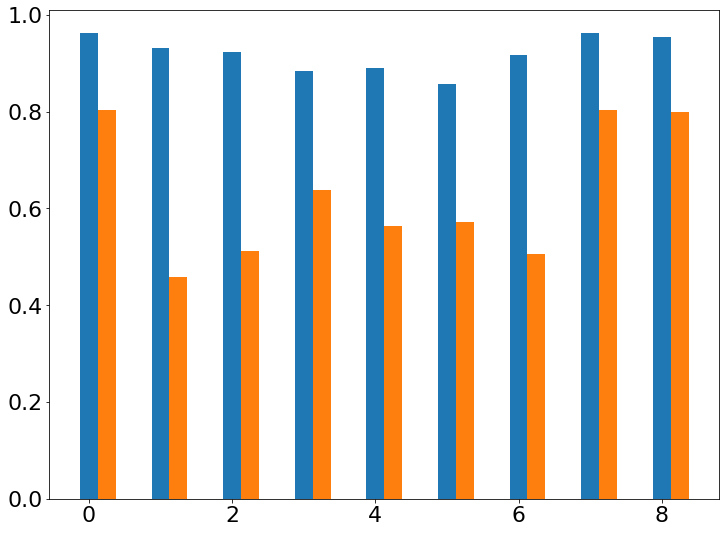

In [27]:
f = open("accuracy_winnow/acc_res_STO_2.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t2 = {}
acc_val2 = []
langs2 = []
students2 = []
for i in data:
    temp = i.split(",")
    print(temp)
    t2[float(temp[1])] = temp[0]
    acc_val2.append(float(temp[1]))
    langs2.append(temp[0])
    students2.append(float(temp[1]))
print(t2[max(acc_val2)])
print(max(acc_val2))

f = open("accuracy_winnow/acc_res_LiAl.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t3 = {}
acc_val3 = []
langs3 = []
students3 = []
for i in data:
    temp = i.split(",")
    print(temp)
    t3[float(temp[1])] = temp[0]
    acc_val3.append(float(temp[1]))
    langs3.append(temp[0])
    students3.append(float(temp[1]))
print(t3[max(acc_val3)])
print(max(acc_val3))

f = open("accuracy_winnow/acc_res_BiTE_1.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t = {}
acc_val = []
langs = []
students = []
for i in data:
    temp = i.split(",")
    print(temp)
    t[float(temp[1])] = temp[0]
    acc_val.append(float(temp[1]))
    langs.append(temp[0])
    students.append(float(temp[1]))
print(t[max(acc_val)])
print(max(acc_val))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#fig = plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(12, 9))
#ax = fig.add_axes([0,0,1,1])
width=0.25
X = np.arange(len(students))
pps = ax.bar(X,students, width)
pps2 = ax.bar(X+width,students2, width)
pps3 = ax.bar(X+2*width, students3, width)

for p in pps:
    height = round(p.get_height(),4)
    ax.annotate('{}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
    
for p in pps2:
    height = round(p.get_height(), 4)
    ax.annotate('{}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
    
for p in pps3:
    height = round(p.get_height(), 4)
    ax.annotate('{}'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 3), # 3 points vertical offset
        textcoords="offset points",
        ha='center', va='bottom')
ax.set_ylabel('Accuracy')
plt.xticks(X, langs,rotation=45)
plt.tight_layout()
plt.savefig("acc_noRes.png")
plt.show()

['ensemble', '0.6092']
['resnet101', '0.5124']
['resnet18', '0.6372']
['resnet34', '0.5632']
['resnet50', '0.5708']
['resnet152', '0.5052']
resnet18
63.72
['ensemble', '0.3361002604166667']
['resnet101', '0.3108723958333333']
['resnet18', '0.3412272135416667']
['resnet34', '0.3353678385416667']
['resnet50', '0.322265625']
['resnet152', '0.3179524739583333']
resnet18
34.12272135416667
['ensemble', '0.8401692708333334']
['resnet101', '0.8294270833333334']
['resnet18', '0.8125']
['resnet34', '0.822265625']
['resnet50', '0.8056640625']
['resnet152', '0.8291015625']
ensemble
84.01692708333334
['ensemble', '0.9166666666666666']
['resnet101', '0.9235026041666666']
['resnet18', '0.884765625']
['resnet34', '0.8889973958333334']
['resnet50', '0.8567708333333334']
['resnet152', '0.9166666666666666']
resnet101
92.35026041666666


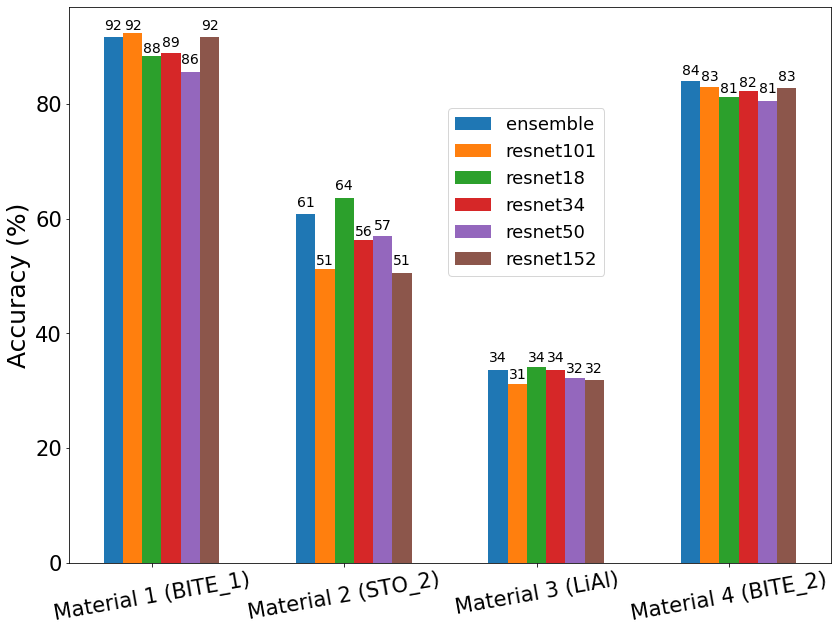

In [33]:
f = open("accuracy_winnow/acc_res_STO_2_RES.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t2 = {}
acc_val2 = []
langs2 = []
students2 = []
for i in data:
    temp = i.split(",")
    if "federated" not in temp[0]:
        print(temp)
        t2[float(temp[1])*100] = temp[0]
        acc_val2.append(float(temp[1])*100)
        langs2.append(temp[0])
        students2.append(float(temp[1])*100)
print(t2[max(acc_val2)])
print(max(acc_val2))

f = open("accuracy_winnow/acc_res.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t3 = {}
acc_val3 = []
langs3 = []
students3 = []
for i in data:
    temp = i.split(",")
    if "federated" not in temp[0]:
        print(temp)
        t3[float(temp[1])*100] = temp[0]
        acc_val3.append(float(temp[1])*100)
        langs3.append(temp[0])
        students3.append(float(temp[1])*100)
print(t3[max(acc_val3)])
print(max(acc_val3))

f = open("accuracy_winnow/acc_res_BiTE_2.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t4 = {}
acc_val4 = []
langs4 = []
students4 = []
for i in data:
    temp = i.split(",")
    if "federated" not in temp[0]:
        print(temp)
        t4[float(temp[1])*100] = temp[0]
        acc_val4.append(float(temp[1])*100)
        langs4.append(temp[0])
        students4.append(float(temp[1])*100)
print(t4[max(acc_val4)])
print(max(acc_val4))

f = open("accuracy_winnow/acc_res_BiTE_1_RES.csv", "r")
data = f.read()
f.close()
data = data.split("\n")
data = data[:-1]
t = {}
acc_val = []
langs = []
students = []
for i in data:
    temp = i.split(",")
    if "federated" not in temp[0]:
        print(temp)
        t[float(temp[1])*100] = temp[0]
        acc_val.append(float(temp[1])*100)
        langs.append(temp[0])
        students.append(float(temp[1])*100)
print(t[max(acc_val)])
print(max(acc_val))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=21)    # fontsize of the tick labels
plt.rc('ytick', labelsize=21)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

fig, ax = plt.subplots(figsize=(12, 9))
width=0.1
X = np.arange(4) #len(students))
#pps = ax.bar(X,students, width) #, label="Material 1 (BITE_1)")
#pps2 = ax.bar(X+width,students2, width) #, width="Material 2 (STO_2)")
#pps3 = ax.bar(X+2*width, students3, width)

#formatting the values to be per material instead of per model
MD = []
mul = 0
for i in range(len(students)):
    MD = [students[i],students2[i],students3[i], students4[i]]
    pps = ax.bar(X+mul*width, MD, width)
    mul += 1
    for p in pps:
        height = round(p.get_height())
        ax.annotate('{}'.format(int(height)),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')
    
#for p in pps2:
#    height = round(p.get_height(), 3)
#    ax.annotate('{}'.format(height),
#        xy=(p.get_x() + p.get_width() / 2, height),
#        xytext=(0, 3), # 3 points vertical offset
#        textcoords="offset points",
#        ha='center', va='bottom')
#for p in pps3:
#    height = round(p.get_height(), 3)
#    ax.annotate('{}'.format(height),
#        xy=(p.get_x() + p.get_width() / 2, height),
#        xytext=(0, 3), # 3 points vertical offset
#        textcoords="offset points",
#        ha='center', va='bottom')
    
ax.set_ylabel('Accuracy (%)',fontsize = 25)
ax.legend(langs, bbox_to_anchor=(0.60, 0.5)) #["Material 1 (BITE_1)", "Material 2 (STO_2)", "Material 3 (LiAl)"])
plt.xticks(X+2*width, ["Material 1 (BITE_1)", "Material 2 (STO_2)", "Material 3 (LiAl)", "Material 4 (BITE_2)"], rotation=10) #langs,rotation=45)
fig.tight_layout()
plt.savefig("acc_Res.png")
plt.show()

In [10]:
count = 0
n_rows = 50
encoder_list = ["resnet101", "resnet18", "resnet34", "resnet50", "resnet152", "torch101", "shufflenet"]
classifier = PychipClassifier(data_path, img_name)
classifier.preprocess("CLAHE", clipLimit=2.0)
classifier.chips_genesis(n_rows, n_columns)
for i in encoder_list:
    support_dict = {'set_3_label': ['R10C49', 'R10C31', 'R10C34', 'R10C37', 'R10C46', 'R0C1', 'R10C30', 'R10C38', 'R10C40', 'R10C45'],
        'particle': ['R20C20', 'R20C23', 'R30C31', 'R30C33', 'R30C8', 'R30C23', 'R30C32', 'R30C34', 'R30C39', 'R30C40'],
        'set_2_label': ['R40C25', 'R40C27', 'R40C24', 'R40C28', 'R40C31', 'R40C5', 'R40C26', 'R40C29', 'R40C30', 'R40C34']}
    #support_dict = {'particle': ['R29C0', 'R21C21', 'R32C17'],
    #            'set_2_label': ['R20C7', 'R15C10', 'R10C20'],
    #            'set_3_label': ['R0C12', 'R1C9']}
    #support_dict = {}
    #for j in ss.keys():
    #    if j not in support_dict.keys():
    #        support_dict[j] = []
    #    count1 = 0
    #    t = ss[j][::5]
    #    while len(support_dict[j]) < 5:
    #        support_dict[j].append(t[count1])
    #        count1 += 1
    #for j in ss.keys():
    #    support_dict[j] = ss[j][:4]
    classifier.support_genesis(support_dict=support_dict)
    classifier.predict(savepath=results_path, encoder=i, seed=75, filename='results_'+i+'.csv') 
    get_acc(i, "accuracy_winnow/acc_res.csv", count, "data/STO_GE_2/STO_GE_2_truth_df.csv", support_dict, dd)
    count += 1
get_best_model("accuracy_winnow/acc_res.csv")

tileGridSize not provided for CLAHE preprocess - using default value: (8,8)
(3000, 3000, 3)
Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
71.22838711738586
[['' 'set_3_label' 'particle' 'set_2_label' 'prediction' 'chip']
 ['R0C0' '1.0' '0.0' '0.0' 'set_3_label' 'R0C0']
 ['R1C0' '0.0' '0.0' '1.0' 'set_2_label' 'R1C0']
 ...
 ['R47C49' '0.0' '0.0' '1.0' 'set_2_label' 'R47C49']
 ['R48C49' '0.0' '0.0' '1.0' 'set_2_label' 'R48C49']
 ['R49C49' '0.0' '0.0' '1.0' 'set_2_label' 'R49C49']]
[['chips' 'class']
 ['R0C0' 'PtC']
 ['R0C1' 'PtC']
 ...
 ['R9C7' 'PtC']
 ['R9C8' 'PtC']
 ['R9C9' 

Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
16.431206703186035
[['' 'set_3_label' 'particle' 'set_2_label' 'prediction' 'chip']
 ['R0C0' '0.9988985061645508' '0.001089103752747178'
  '1.2385097761580255e-05' 'set_3_label' 'R0C0']
 ['R1C0' '0.00019430422980803996' '0.19460169970989227'
  '0.8052039742469788' 'set_2_label' 'R1C0']
 ...
 ['R47C49' '1.0075800673803315e-05' '0.014025901444256306'
  '0.9859640598297119' 'set_2_label' 'R47C49']
 ['R48C49' '2.8543121516122483e-05' '0.038767240941524506'
  '0.9612042307853699' 'set_2_label' 'R48C49']
 ['R49C49' '3.302192999399267e-

Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
51.154067039489746
[['' 'set_3_label' 'particle' 'set_2_label' 'prediction' 'chip']
 ['R0C0' '1.0' '0.0' '0.0' 'set_3_label' 'R0C0']
 ['R1C0' '0.0' '0.0' '1.0' 'set_2_label' 'R1C0']
 ...
 ['R47C49' '0.0' '0.0' '1.0' 'set_2_label' 'R47C49']
 ['R48C49' '0.0' '0.0' '1.0' 'set_2_label' 'R48C49']
 ['R49C49' '0.0' '0.0' '1.0' 'set_2_label' 'R49C49']]
[['chips' 'class']
 ['R0C0' 'PtC']
 ['R0C1' 'PtC']
 ...
 ['R9C7' 'PtC']
 ['R9C8' 'PtC']
 ['R9C9' 'PtC']]
{'set_3_label': ['R10C49', 'R10C31', 'R10C34', 'R10C37', 'R10C46', 'R0C1', 'R10C30'

Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
75.54079389572144
[['' 'set_3_label' 'particle' 'set_2_label' 'prediction' 'chip']
 ['R0C0' '1.0' '0.0' '0.0' 'set_3_label' 'R0C0']
 ['R1C0' '0.0' '1.2144759517625681e-39' '1.0' 'set_2_label' 'R1C0']
 ...
 ['R47C49' '0.0' '0.0' '1.0' 'set_2_label' 'R47C49']
 ['R48C49' '0.0' '7.283963430545042e-40' '1.0' 'set_2_label' 'R48C49']
 ['R49C49' '0.0' '1.4293244336113134e-43' '1.0' 'set_2_label' 'R49C49']]
[['chips' 'class']
 ['R0C0' 'PtC']
 ['R0C1' 'PtC']
 ...
 ['R9C7' 'PtC']
 ['R9C8' 'PtC']
 ['R9C9' 'PtC']]
{'set_3_label': ['R10C49', '

Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
163.93169736862183
[['' 'set_3_label' 'particle' 'set_2_label' 'prediction' 'chip']
 ['R0C0' '1.0' '0.0' '0.0' 'set_3_label' 'R0C0']
 ['R1C0' '0.0' '0.0' '1.0' 'set_2_label' 'R1C0']
 ...
 ['R47C49' '0.0' '0.0' '1.0' 'set_2_label' 'R47C49']
 ['R48C49' '0.0' '0.0' '1.0' 'set_2_label' 'R48C49']
 ['R49C49' '0.0' '0.0' '1.0' 'set_2_label' 'R49C49']]
[['chips' 'class']
 ['R0C0' 'PtC']
 ['R0C1' 'PtC']
 ...
 ['R9C7' 'PtC']
 ['R9C8' 'PtC']
 ['R9C9' 'PtC']]
{'set_3_label': ['R10C49', 'R10C31', 'R10C34', 'R10C37', 'R10C46', 'R0C1', 'R10C30'

Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
122.39592909812927
[['' 'set_3_label' 'particle' 'set_2_label' 'prediction' 'chip']
 ['R0C0' '1.0' '9.382505623128923e-13' '1.4315030516526312e-18'
  'set_3_label' 'R0C0']
 ['R1C0' '1.0' '4.0335842305117e-11' '7.670304206883357e-17'
  'set_3_label' 'R1C0']
 ...
 ['R47C49' '2.3267148028128376e-17' '9.654524183133617e-05'
  '0.9999034404754639' 'set_2_label' 'R47C49']
 ['R48C49' '8.068213815723825e-17' '2.2343134332913905e-05'
  '0.999977707862854' 'set_2_label' 'R48C49']
 ['R49C49' '2.2237431249975004e-15' '0.000654560630209744'
 

Computing batch 0
Computing batch 1
Computing batch 2
Computing batch 3
Computing batch 4
Computing batch 5
Computing batch 6
Computing batch 7
Computing batch 8
Computing batch 9
Computing batch 10
Computing batch 11
Computing batch 12
Computing batch 13
Computing batch 14
Computing batch 15
Computing batch 16
Computing batch 17
Computing batch 18
Computing batch 19
Computing batch 20
Computing batch 21
Computing batch 22
Computing batch 23
Computing batch 24
20.001336812973022
[['' 'set_3_label' 'particle' 'set_2_label' 'prediction' 'chip']
 ['R0C0' '0.9994592070579529' '0.0005406885757111013'
  '1.3134126675140578e-07' 'set_3_label' 'R0C0']
 ['R1C0' '0.9384625554084778' '0.06150887906551361'
  '2.8515831218101084e-05' 'set_3_label' 'R1C0']
 ...
 ['R47C49' '2.1978371123054785e-08' '0.04976145178079605'
  '0.9502385258674622' 'set_2_label' 'R47C49']
 ['R48C49' '3.404044823795971e-09' '0.004017411265522242'
  '0.9959826469421387' 'set_2_label' 'R48C49']
 ['R49C49' '2.9409454782580724e-

## Step 6: Interpret results

The classifier has two properties that are most useful for interpreting the results:
- color_image (saves a segmented image with customized colors (according to the ```color_dict``` created above)
- results (returns a dataframe of predicted classes)

In [ ]:
# this may take a while to execute
classifier.color_image(savepath=results_path, img_name='results.jpg', color_dict=color_dict)

In [ ]:
classifier.results.head(10)